In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive 
#from tqdm import tqdm
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive


In [0]:
!unzip "Copy of Assignment 5 Dataset.zip"

In [0]:
data_dir_Train = '/content/gdrive/My Drive/Assignment 5 Dataset/train'
data_dir_Test = '/content/gdrive/My Drive/Assignment 5 Dataset/test'
data_dir_valid = '/content/gdrive/My Drive/Assignment 5 Dataset/validation'


In [4]:
#Define transforms for the training data and testing data
#pass transform here-in
train_transforms = transforms.Compose([transforms.Resize((224,224), interpolation=2),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(root=data_dir_Train, transform=train_transforms)
test_data = datasets.ImageFolder(root=data_dir_Test, transform=train_transforms)
valid_data = datasets.ImageFolder(root=data_dir_valid, transform=train_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True, num_workers=8)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True,num_workers=8)

print("Training Data Classes: ")
class_names_Train = train_data.classes
print(class_names_Train)

print("Validation Data Classes: ")
class_names_Valid = valid_data.classes
print(class_names_Valid)

print("Test Data Classes: ")
class_names_Test = test_data.classes
print(class_names_Test)

Training Data Classes: 
['infected', 'normal']
Validation Data Classes: 
['infected', 'normal']
Test Data Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


here man torch.Size([128, 3, 224, 224])
in function (228, 1584, 3)


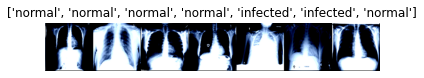

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    print('in function', inp.shape)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names_Train[x] for x in classes])

# Get a batch of training data
#trainloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
inputs, classes = next(iter(trainloader))
print('here man', inputs.shape)
show_databatch(inputs[0:7], classes[0:7])

In [0]:
def validation_loss_in_epoch(model, validloader):
    total = 0
    correct = 0
    loss = 0
    
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += Loss_criteria(outputs, labels)   #----> compute loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total, loss/total

In [0]:

def training(model, model_optimizer, Loss_criteria, trainloader, validloader, epoch, lr_schedule):
    
    train_loss_epoch = []
    valid_loss_epoch = []
    train_accu_epoch = []
    valid_accu_epoch = []
    correct_train = 0
    total_train = 0
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #model.to(device)

    model.train()

    for epoch in range(epochs): 
        correct_train = 0
        total_train = 0
        execution_loss = 0.0
        pbar = tqdm(enumerate(trainloader))
    
        for i, data in pbar:
            # get the inputs
        
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            model_optimizer.zero_grad()
        

            # forward + backward + optimize
            outputs = model(inputs)               #----> forward pass
            loss = Loss_criteria(outputs, labels)   #----> compute loss
            loss.backward()                     #----> backward pass
            model_optimizer.step()                    #----> weights update

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            # print statistics
            execution_loss += loss.item()
        
            pbar.set_description(
                'Epoch: {} [{}/{} ({:.0f}%)]\tAccu: {:.2f}  '.format(
                    epoch, i * len(inputs), len(trainloader.dataset),
                    100. * i / len(trainloader),
                    correct_train*100/total_train))
        
        train_loss_epoch.append(execution_loss/total_train)
        train_accu_epoch.append(100 * correct_train / total_train)
        accu, loss_valid = validation_loss_in_epoch(model, validloader)
        valid_loss_epoch.append(loss_valid.data)
        valid_accu_epoch.append(accu)
        #lr_schedule.step(100 * correct_train / total_train)
        lr_schedule.step(accu)
        if train_accu_epoch[epoch] >= 99.9:
            break
        #torch.save(vgg16.state_dict(), '‘vgg16_FC_Only.pth')

    epochs_arr = list(range(0,epoch+1))

    fig= plt.gcf()
    fig.show()
    fig.set_size_inches(15, 5.5)
    plt.subplot(121)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.plot(epochs_arr,train_loss_epoch, "-b", label="Training Cost")
    plt.plot(epochs_arr,valid_loss_epoch, "-g", label="Validation Cost")
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(epochs_arr,train_accu_epoch, "-b", label="Training Accuracy")
    plt.plot(epochs_arr,valid_accu_epoch, "-g", label="VAlidation Accuracy")
    plt.legend(loc='lower right')



    print('Finished Training')
    
    return model

In [0]:
def Test_accuracy(model, testloader):
    correct = 0
    total = 0
    f1 = 0
    count = 0
    with torch.no_grad():
        for data in testloader:
            label_list = []
            predictedList = []
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            label_list.append(labels.cpu().numpy())
            predictedList.append(predicted.cpu().numpy())
            f1 += f1_score(label_list, predictedList, average="samples", zero_division='warn')

            count += 1
    print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
    
    print('F1 Score is ',f1 / count)
    
    return 

In [9]:
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
print('Output Layer of Resnet18 : ', resnet18.fc.out_features)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [10]:
FC_Layer_size = resnet18.fc.in_features
print(FC_Layer_size)

512


In [11]:
# removing the FC layers

FC_Layer_features = list(resnet18.fc.children())[:-1]
#Classifier_features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(FC_Layer_features)

[]


In [12]:
FC_Layer_features.extend([nn.Linear(FC_Layer_size, 4*10 + 100)]) 
FC_Layer_features.extend([nn.ReLU(inplace=True)])
FC_Layer_features.extend([nn.Dropout(p=0.5, inplace=False)])
FC_Layer_features.extend([nn.Linear(4*10+100, len(class_names_Train))])
resnet18.fc = nn.Sequential(*FC_Layer_features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze training for all CNN layers

for parameters in resnet18.parameters():
    parameters.requires_grad = False

#for parameters in resnet18.layer2.parameters():
#    parameters.requires_grad = False
#for parameters in resnet18.layer3.parameters():
#    parameters.requires_grad = True
#for parameters in resnet18.layer4.parameters():
#    parameters.requires_grad = True

for parameters in resnet18.fc.parameters():
    parameters.requires_grad = True
    
i = 0
for parameters in resnet18.parameters():
    print(i, parameters.requires_grad)
    i += 1


Finished Training


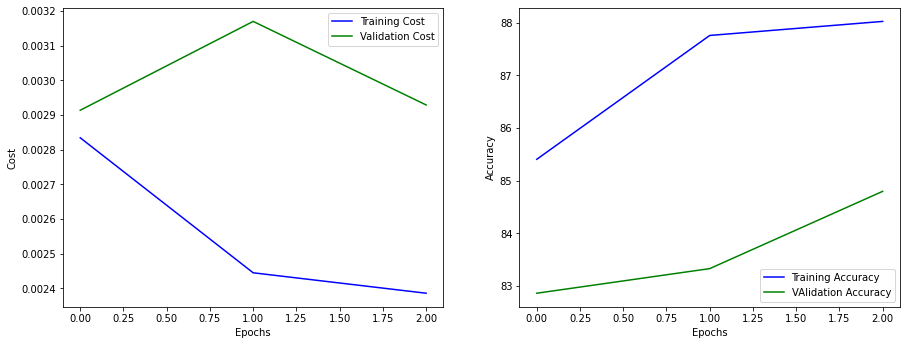

In [0]:
epochs = 3
Loss_criteria = nn.CrossEntropyLoss()
#resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.0025, momentum=0.90)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18_optimizer = optim.Adagrad(resnet18.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(resnet18_optimizer, 'max', factor=0.9, patience=2)

resnet18 = training(resnet18, resnet18_optimizer,Loss_criteria, trainloader, validloader, epochs, lr_schedule)

In [13]:
resnet18.load_state_dict(torch.load('res18_entire.pth'))

<All keys matched successfully>

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
Test_accuracy(resnet18, testloader)

Accuracy of the network on the test images: 97 %
F1 Score is  0.9770958980238312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


in function (228, 906, 3)


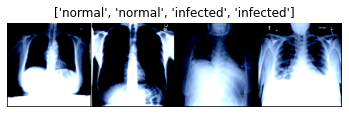

In [250]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images[0:4], labels[0:4])

In [251]:
images, labels = images[0:4].to(device), labels[0:4].to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names_Test[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names_Test[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal infected infected
Ground Truth:  normal normal infected infected


In [16]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [17]:
Classifier_Layer_size = vgg16.classifier[0].in_features
print(Classifier_Layer_size)

25088


In [18]:
# removing the FC layers

Classifier_features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(Classifier_features)

[]


In [19]:
# Adding FC layers according to assignment

Classifier_features.extend([nn.Linear(Classifier_Layer_size, 4*10 + 100)])      # My roll number's last two digits are 04
Classifier_features.extend([nn.ReLU(inplace=True)])
Classifier_features.extend([nn.Dropout(p=0.5, inplace=False)])
Classifier_features.extend([nn.Linear(4*10+100, len(class_names_Train))])
vgg16.classifier = nn.Sequential(*Classifier_features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Freeze training for all CNN layers

for parameters in vgg16.features.parameters():
    parameters.requires_grad = True
for parameters in vgg16.classifier.parameters():
    parameters.requires_grad = True


Finished Training


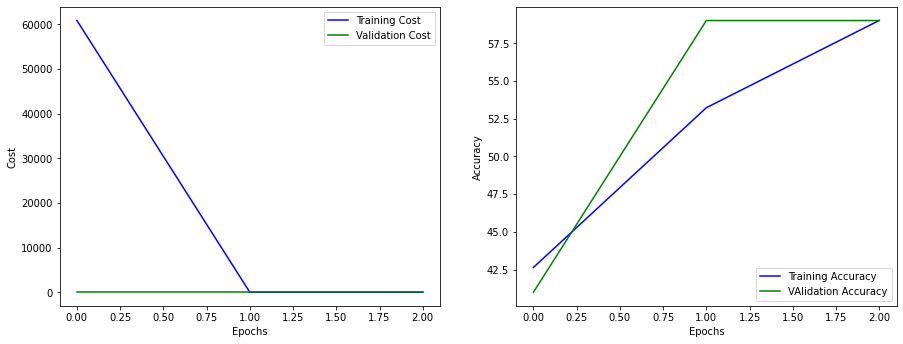

In [0]:
epochs = 3
Loss_criteria = nn.CrossEntropyLoss()
#vgg16_optimizer = optim.SGD(vgg16.parameters(), lr=0.0025, momentum=0.90)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16_optimizer = optim.Adagrad(vgg16.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(vgg16_optimizer, 'max', factor=0.9, patience=2)

vgg16 = training(vgg16, vgg16_optimizer,Loss_criteria, trainloader, validloader, epochs, lr_schedule)

In [23]:
vgg16.load_state_dict(torch.load('vgg16_entire.pth'))

<All keys matched successfully>

In [24]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
Test_accuracy(vgg16, testloader)

Accuracy of the network on the test images: 96 %
F1 Score is  0.9725748715462883
